In [115]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot
import cav as cav

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import scipy

In [2]:
model = load_model('v3_model.h5')

Instructions for updating:
Colocations handled automatically by placer.


/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [186]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

In [187]:
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'


## Making predictions example

In [216]:
img_path = 'concepts/zebra/img109.jpg'

img = prep(img_path)
preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})

In [217]:
decode_predictions(preds, top=3)

[[('n02391049', 'zebra', 0.95421046),
  ('n01518878', 'ostrich', 0.00059850555),
  ('n02422106', 'hartebeest', 0.00044661458)]]

In [ ]:
## define input image

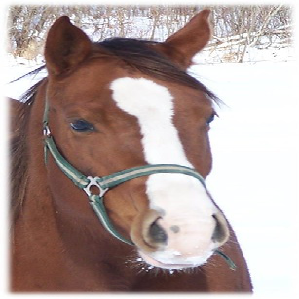

In [231]:
#img_path = 'concepts/noise_white/img10.jpg'
#img_path = 'concepts/noise_black/img10.jpg'
img_path = 'concepts/horse_sub_1/img184.jpg'

test_img = image.load_img(img_path, target_size=(299, 299))
test_img

In [232]:
## activations at layer x

In [233]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()

layer_name = 'mixed9'
acts_9 = layer_dict[layer_name].output
get_acts_9_func = K.function([model.input],[acts_9])

def get_acts_9(input_img):
    outs = get_acts_9_func([input_img])
    acts_value = outs[0]
    return acts_value

layer_name = 'predictions'
acts_pred = layer_dict[layer_name].output
get_preds_func = K.function([model.input],[acts_pred])

def get_preds(input_img):
    outs = get_preds_func([input_img])
    acts_value = outs[0]
    return acts_value

## optimizae idx 340 for zebra
zebra_pred = np.zeros((1000,1))
zebra_pred[340] = 1

loss = K.variable(0.)

zebra_tensor = K.constant(zebra_pred)
preds = layer_dict['predictions'].output

print('zebra_tensor shape is ' + str(zebra_tensor.shape))
print('preds shape is ' + str(preds.shape))

loss += K.dot(preds,zebra_tensor)

grads = K.gradients(loss, model.input)[0]
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

outputs = [loss, grads]
fetch_loss_and_grads = K.function([model.input], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        if i % 1 == 0:
            print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

zebra_tensor shape is (1000, 1)
preds shape is (?, 1000)


In [234]:
## from activations, gradient descent to class direction
iterations = 50
step = .05
max_loss = .95

img = prep(img_path)

img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
img_name = 'optimal'
save_img(img, fname='results/' + img_name + '.png')

..Loss value at 0 : [[4.774444e-05]]
..Loss value at 1 : [[0.00079303]]
..Loss value at 2 : [[0.00213728]]
..Loss value at 3 : [[0.46433124]]


/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()


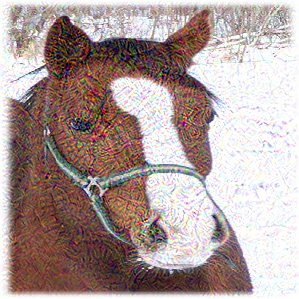

In [235]:
#img_name
res_path = 'results/' + img_name + '.png'
test_img = image.load_img(res_path, target_size=(299, 299))
test_img

In [229]:
img = prep(res_path)
preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})

In [230]:
decode_predictions(preds, top=3)

[[('n02391049', 'zebra', 0.95209086),
  ('n02749479', 'assault_rifle', 0.0016767564),
  ('n03598930', 'jigsaw_puzzle', 0.0014816344)]]

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()

layer_name = 'mixed9'
acts_9 = layer_dict[layer_name].output
get_acts_9_func = K.function([model.input],[acts_9])

def get_acts_9(input_img):
    outs = get_acts_9_func([input_img])
    acts_value = outs[0]
    return acts_value

layer_name = 'predictions'
acts_pred = layer_dict[layer_name].output
get_preds_func = K.function([model.input],[acts_pred])

def get_preds(input_img):
    outs = get_preds_func([input_img])
    acts_value = outs[0]
    return acts_value

## optimizae idx 340 for zebra
zebra_pred = np.zeros((1000,1))
zebra_pred[340] = 1

loss = K.variable(0.)

zebra_tensor = K.constant(zebra_pred)
preds = layer_dict['predictions'].output

print('zebra_tensor shape is ' + str(zebra_tensor.shape))
print('preds shape is ' + str(preds.shape))

loss += K.dot(preds,zebra_tensor)

grads = K.gradients(loss, model.input)[0]
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

outputs = [loss, grads]
fetch_loss_and_grads = K.function([model.input], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        if i % 1 == 0:
            print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [ ]:
## from activations, gradient descent to class direction
iterations = 50
step = .05
max_loss = .95

img = prep(img_path)
acts_9 = get_acts_9(img):

img = gradient_ascent_acts(img,iterations=iterations,step=step,max_loss=max_loss)
img_name = 'optimal'
save_img(img, fname='results/' + img_name + '.png')

In [ ]:
def get_preds(input_img):
    outs = get_preds_func([input_img])
    acts_value = outs[0]
    return acts_value

In [213]:
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_prediction(img):
    img = preprocess_input(img)
    preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
    top = decode_predictions(preds, top=3)
    return top

def prep(path):
    img_pic = image.load_img(path, target_size=(299, 299))
    img = image.img_to_array(img_pic)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img